# Sales Projections - Final

The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increase sales.

To finalize this project, your task is to improve your model to predict sales and prepare a short (5-10 minute) presentation about your project.

*   Finalize your README with an overview of the project, an explanation of the data (including visualizations), and a summary of the results and recommendations. Think of this as an executive summary or an overview of your project.
*   Prepare a short (5-10 minute) presentation. Record yourself giving this presentation. Feel free to use any software available (Zoom, OBS, etc.). Include this recording on your GitHub repo.
*   Make sure your GitHub repository is organized and professional. Remember, this should be used to showcase your data science skills and abilities.

**Data Dictionary:**

**Name** | **Type** |  **Subtype**|  **Description**|  **Segment**|**Expectation**
--- | --- | --- | --- | --- | ---
**Item Identifier** | categorical | nominal | Unique product ID | Product | Low Impact
**Item Weight** | numerical | continuous | Weight of product | Product | Medium Impact
**Item Fat Content** | categorical | ordinal | Whether the product is low fat or regular | Product | Medium Impact
**Item Visibility** | numerical | continuous | The percentage of total display area of all products in a store allocated to the particular product | Product | High Impact
**Item Type** | categorical | nominal | The category to which the product belongs | Product | High Impact
**Item MRP** | numerical | continuous | Maximum Retail Price (list price) of the product | Product | Medium Impact
**Outlet Identifier** | categorical | nominal | Unique store ID | Store | Low Impact
**Outlet Establishment Year** | numerical | continuous | The year in which store was established | Store | Low Impact
**Outlet Size** | categorical | ordinal | The size of the store in terms of ground area covered | Store | High Impact
**Outlet Location Type** | categorical | nominal | The type of area in which the store is located | Store | High Impact
**Outlet Type** | categorical | nominal | Whether the outlet is a grocery store or some sort of supermarket | Store | High Impact
**Item Outlet Sales** | numerical | continuous | Sales of the product in the particular store. This is the target variable to be predicted. | Product | Target

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

data = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Project 1_Sales Predictions/sales_predictions.csv',index_col=False)
data.head().T

,0,1,2,3,4
Item_Identifier,FDA15,DRC01,FDN15,FDX07,NCD19
Item_Weight,9.3,5.92,17.5,19.2,8.93
Item_Fat_Content,Low Fat,Regular,Low Fat,Regular,Low Fat
Item_Visibility,0.0160473,0.0192782,0.0167601,0,0
Item_Type,Dairy,Soft Drinks,Meat,Fruits and Vegetables,Household
Item_MRP,249.809,48.2692,141.618,182.095,53.8614
Outlet_Identifier,OUT049,OUT018,OUT049,OUT010,OUT013
Outlet_Establishment_Year,1999,2009,1999,1998,1987
Outlet_Size,Medium,Medium,Medium,NaN,High
Outlet_Location_Type,Tier 1,Tier 3,Tier 1,Tier 3,Tier 3


In [32]:
data.groupby('Item_Identifier').sum().sort_values('Item_Outlet_Sales',ascending=False).head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Identifier,,,,,
FDY55,100.5,0.407141,2058.1904,15968,42661.8008
FDA15,65.1,0.139094,1995.9736,15991,41584.5364
FDZ20,112.7,0.263547,2032.8848,15979,40185.0248
FDF05,122.5,0.215167,2103.1280,15990,36555.7490
FDA04,79.1,0.534337,2072.0696,15990,35741.4756


In [33]:
data.groupby('Item_Identifier').sum().sort_values('Item_Outlet_Sales',ascending=True).head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Identifier,,,,,
FDQ60,0.000,0.191501,121.2098,1985,120.5098
NCR42,27.315,0.141670,101.0700,6007,332.9000
FDY43,14.850,0.098803,169.7474,2009,673.7896
FDF38,23.600,0.052694,80.2276,3984,771.6622
FDQ04,12.800,0.375138,121.9388,5982,784.3124


**Data Pre-Processing**

Identify Missing Data

In [34]:
total_df = data.isnull().sum().sort_values(ascending=False)
percent_missing1 = data.isnull().sum()/data.isnull().count() * 100
percent_missing2 = (round(percent_missing1, 1)).sort_values(ascending=False)
missing_table = pd.concat([total_df, percent_missing2,],
                          axis=1, keys=['Total','% Missing'])
missing_table.head(2)

,Total,% Missing
Outlet_Size,2410,28.3
Item_Weight,1463,17.2


Imputing Missing Data

*    Outlet_Size
*    Item_Weight
*    Item_Visibility (convert 0 values to NaN)

In [35]:
mode_os = data['Outlet_Size'].mode()
mean_iw = int(data['Item_Weight'].mean())
data.Item_Visibility.replace(to_replace=0.000000,value=np.NaN,inplace=True)

data['Outlet_Size'].fillna('Medium', inplace = True)
data['Item_Weight'].fillna(mean_iw, inplace = True)
data.Item_Visibility = data.Item_Visibility.fillna(data.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [36]:
# get the first two characters of ID
data['Item_Category'] = data['Item_Identifier'].apply(lambda x: x[:2])
# rename to new categories
data['Item_Category'] = data['Item_Category'].map({'FD':'Food',
                                                   'NC':'Non-Consumable',
                                                   'DR':'Drinks'})
data['Item_Category'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Category, dtype: int64

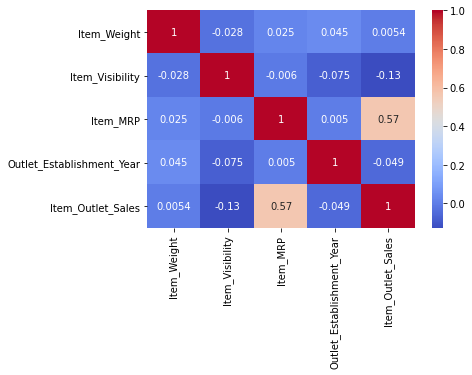

In [37]:
corr = data.corr()
# sns.color_palette("hls", 8)
sns.heatmap(corr, annot=True, cmap='coolwarm');

**Graph 1:** 

Same Store Sales Projections - Impact of Outlet_Identifier on Item_Outlet_Sales

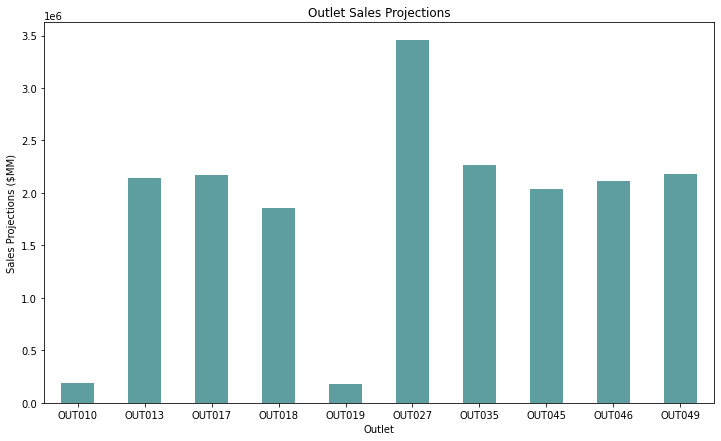

In [38]:
outlet_identifier_pivot = \
data.pivot_table(index= 'Outlet_Identifier', values= 'Item_Outlet_Sales', aggfunc=np.sum)
outlet_identifier_pivot.plot(kind='bar', color='cadetblue',legend=None, figsize=(12,7))
plt.xlabel('Outlet')
plt.ylabel('Sales Projections ($MM)')
plt.title('Outlet Sales Projections')
plt.xticks(rotation=0)
plt.savefig('Outlet Sales Projections',fontsize = 14, y=1.02);
plt.show()

In [39]:
gb1 = data.groupby('Outlet_Identifier').Item_Outlet_Sales.agg(['mean','sum']).style.format('${0:,.0f}')
gb1

,mean,sum
Outlet_Identifier,,
OUT010,$339,"$188,340"
OUT013,"$2,299","$2,142,664"
OUT017,"$2,341","$2,167,465"
OUT018,"$1,995","$1,851,823"
OUT019,$340,"$179,694"
OUT027,"$3,694","$3,453,926"
OUT035,"$2,439","$2,268,123"
OUT045,"$2,192","$2,036,725"
OUT046,"$2,278","$2,118,395"


**Graph 2:** 

Sales Projections by Item Category - Impact of Item_Category on Item_Outlet_Sales

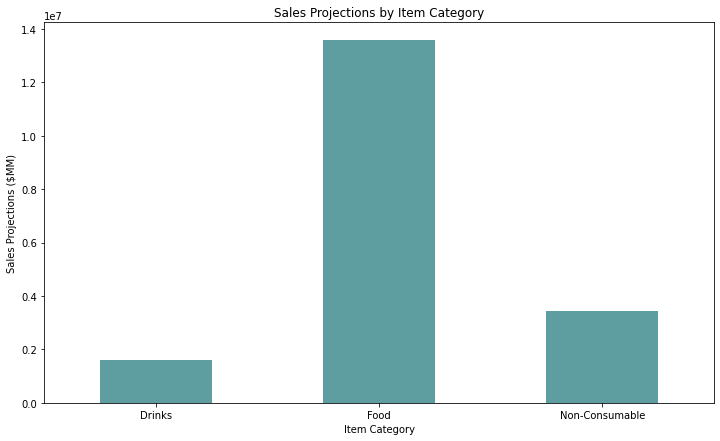

In [40]:
item_category_pivot = \
data.pivot_table(index= 'Item_Category', values= 'Item_Outlet_Sales', aggfunc=np.sum)
item_category_pivot.plot(kind='bar', color='cadetblue',legend=None, figsize=(12,7))
plt.xlabel('Item Category')
plt.ylabel('Sales Projections ($MM)')
plt.title('Sales Projections by Item Category')
plt.xticks(rotation=0)
plt.savefig('Sales Projections by Item Category',fontsize = 14, y=1.02);
plt.show()

In [41]:
gb2 = data.groupby('Item_Category').Item_Outlet_Sales.agg(['mean','sum']).style.format('${0:,.0f}')
gb2

,mean,sum
Item_Category,,
Drinks,"$1,997","$1,595,869"
Food,"$2,215","$13,569,045"
Non-Consumable,"$2,143","$3,426,211"


**Graph 3:** 

Sales Projections by Item Type - Impact of Item_Type on Item_Outlet_Sales

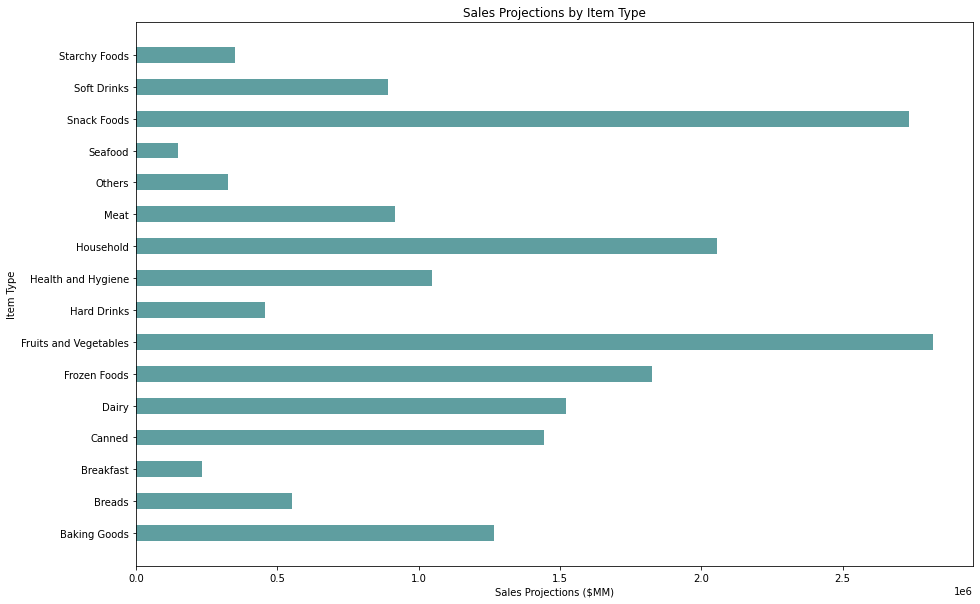

In [42]:
item_type_pivot = \
data.pivot_table(index= 'Item_Type', values= 'Item_Outlet_Sales', aggfunc=np.sum)
item_type_pivot.plot(kind='barh', color='cadetblue',legend=None, figsize=(15,10))
plt.ylim(bottom=0)
plt.ylim(top=15000)
plt.xlabel('Sales Projections ($MM)')
plt.ylabel('Item Type')
plt.title('Sales Projections by Item Type')
# plt.xticks(rotation=90)
plt.autoscale()
plt.savefig('Sales Projections by Item Type',fontsize = 14, y=1.02);
plt.show()

In [43]:
gb3 = data.groupby(['Outlet_Type','Outlet_Identifier','Item_Category']).Item_Outlet_Sales.agg(['sum']).style.format('${0:,.0f}')
gb3

**Graph 4:** 

Sales Projections by Outlet Type - Impact of Outlet_Type on Item_Outlet_Sales

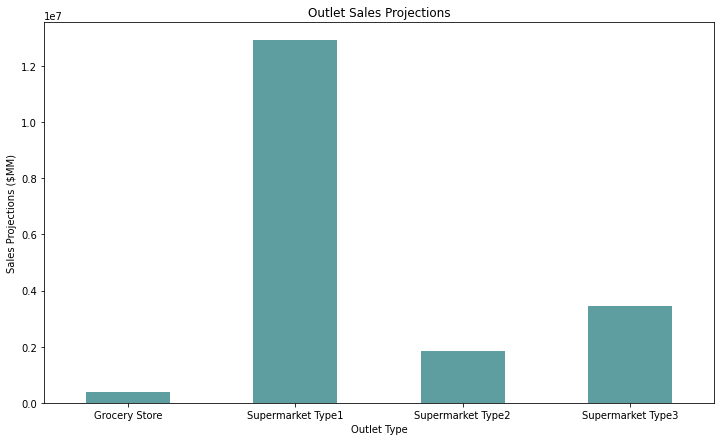

In [44]:
outlet_identifier_pivot = \
data.pivot_table(index= 'Outlet_Type', values= 'Item_Outlet_Sales', aggfunc=np.sum)
outlet_identifier_pivot.plot(kind='bar', color='cadetblue',legend=None, figsize=(12,7))
plt.xlabel('Outlet Type')
plt.ylabel('Sales Projections ($MM)')
plt.title('Outlet Sales Projections')
plt.xticks(rotation=0)
plt.savefig('Outlet Sales Projections',fontsize = 14, y=1.02);
plt.show()

In [45]:
# list of categorical features
cat_col = []
for x in data.dtypes.index:
  if data.dtypes[x] == 'object':
      cat_col.append(x)
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Category']

In [46]:
data = data.drop(columns=['Outlet_Establishment_Year','Item_Identifier','Outlet_Identifier'])
data

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Category
0,9.300,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380,Food
1,5.920,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228,Drinks
2,17.500,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700,Food
3,19.200,Regular,0.022911,Fruits and Vegetables,182.0950,Medium,Tier 3,Grocery Store,732.3800,Food
4,8.930,Low Fat,0.016164,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,High,Tier 3,Supermarket Type1,2778.3834,Food
8519,8.380,Regular,0.046982,Baking Goods,108.1570,Medium,Tier 2,Supermarket Type1,549.2850,Food
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,Small,Tier 2,Supermarket Type1,1193.1136,Non-Consumable
8521,7.210,Regular,0.145221,Snack Foods,103.1332,Medium,Tier 3,Supermarket Type2,1845.5976,Food


**One Hot Encoder**

In [47]:
data_dummies = pd.get_dummies(data, columns=['Item_Fat_Content', 'Item_Type','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category'])
data = data_dummies
data

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Category_Drinks,Item_Category_Food,Item_Category_Non-Consumable
0,9.300,0.016047,249.8092,3735.1380,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,5.920,0.019278,48.2692,443.4228,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
2,17.500,0.016760,141.6180,2097.2700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
3,19.200,0.022911,182.0950,732.3800,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0
4,8.930,0.016164,53.8614,994.7052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,2778.3834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
8519,8.380,0.046982,108.1570,549.2850,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
8520,10.600,0.035186,85.1224,1193.1136,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
8521,7.210,0.145221,103.1332,1845.5976,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0


**Modeling**

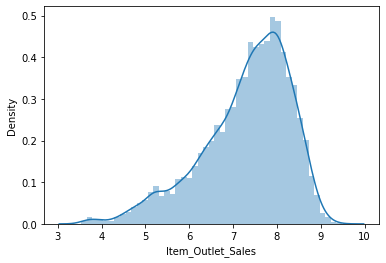

In [48]:
# Model Optimization 
# log transformation Item_Outlet_Sales due to larger values 
data.Item_Outlet_Sales = np.log(1+data.Item_Outlet_Sales)
sns.distplot(data.Item_Outlet_Sales);

# Item_Outlet_Sales is near normal distribution and small numbers

In [49]:
y = data['Item_Outlet_Sales']
X = data.drop(columns=['Item_Outlet_Sales'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print('R^2:', model.score(X_test, y_test))

R^2: 0.7263891297342681


Model Report
 
MSE: 0.41581017768953044
RMSE: 0.5364600796472679
CV Score 0.2899884984321317
 


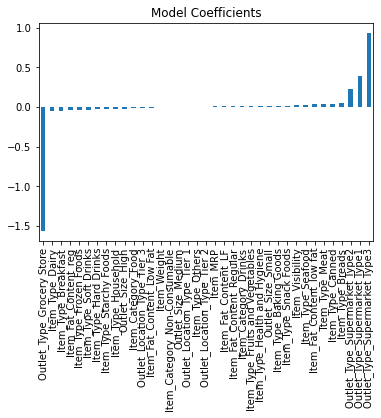

In [50]:
def train(model, X, y):
  model.fit(X,y)
  pred = model.predict(X)
  cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error')
  cv_score = np.abs(np.mean(cv_score))

  print('Model Report')
  print(' ')
  print('MSE:', metrics.mean_absolute_error(y,pred))
  print('RMSE:', np.sqrt(mean_squared_error(y,pred)))
  print('CV Score', cv_score)
  print(' ')
model = LinearRegression()
train(model, X, y)
coef = pd.Series(model.coef_,X.columns).sort_values()
coef.plot(kind='bar',title='Model Coefficients');

In [52]:
results = pd.DataFrame({'Actual': y_test,'Predicted': predictions})
results.head()

,Actual,Predicted
1070,6.860412,6.658983
6305,7.034262,6.930162
8504,8.328358,7.779589
5562,7.413474,7.119310
1410,6.522263,6.684435


**Citations**

1. https://stackoverflow.com/questions/46045750/python-distplot-with-multiple-distributions
2. https://www.geeksforgeeks.org/check-multiple-conditions-in-if-statement-python/
3. https://www.youtube.com/watch?v=CD58mco2XqA